In [3]:
import sys
print(sys.executable)
from pylidar_tls_canopy import riegl_io, plant_profile, grid, visualize

/home/kdayal/miniforge3/envs/ptc/bin/python


ModuleNotFoundError: No module named 'pylidar_tls_canopy'

In [7]:
x = "this is running inside tmux"

In [8]:
print (x)

this is running inside tmux


In [2]:
import os

import numpy as np

import glob

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator

from pylidar_tls_canopy import riegl_io, plant_profile, grid

from os import walk

import pandas as pd
#import openpyxl
from pathlib import Path
import shutil
import math


import timeit
import riegl_rdb

import ast
import re
from datetime import datetime
import json 



In [8]:
np.set_printoptions(threshold=np.inf, linewidth=200)
pd.set_option('display.max_colwidth', None)

In [2]:
def getpaths(projscan):
    
    dir = os.listdir(os.path.join(projpath, 'project.rdb', 'SCANS', projscan, "SINGLESCANS"))
    dir = [x for x in dir if "@" not in x]
    if len(dir)>1:
        dir = max(dir)
    rdbpath = os.listdir(os.path.join(projpath, 'project.rdb', 'SCANS', projscan, "SINGLESCANS", dir[0]))
    rdbpath = [x for x in rdbpath if x.endswith('.rdbx')]
    rxpname = os.path.splitext(rdbpath[0])[0]+ ".rxp"
    for root, dirs, files in os.walk(os.path.join(projpath, "SCANS")):
        if rxpname in files:
            rxpath = os.path.join(root, rxpname)
    rdbpath = os.path.join(projpath, 'project.rdb', 'SCANS', projscan, "SINGLESCANS", str(dir[0]), str(rdbpath[0]))
    sopname = projscan+".DAT"
    for root, dirs, files in os.walk(os.path.join(projpath,"Matrices")):
        if sopname in files:
            sopath = os.path.join(root, sopname)
    return [rdbpath, rxpath, sopath]

In [13]:
projpaths = ['/Stor2/karun/data/benchmarking/reprocessed/germany/gfz/01/pos1.RiSCAN/',
             '/Stor2/karun/data/benchmarking/reprocessed/germany/gfz/02/pos2.RiSCAN/']

all_path_tables = []  # will store one DataFrame per project

for projpath in projpaths:
    scan_root = os.path.join(projpath, 'project.rdb', 'SCANS')
    if not os.path.exists(scan_root):
        continue

    projscanpos = sorted(os.listdir(scan_root))

    paths = list(map(getpaths, projscanpos))
    paths = pd.DataFrame(paths)

    # Split into vertical and horizontal
    split = len(paths) // 2
    paths_v = paths.iloc[:split].reset_index(drop=True)
    paths_v.columns = ["rdb_v", "rxp_v", "dat_v"]

    paths_h = paths.iloc[split:].reset_index(drop=True)
    paths_h.columns = ["rdb_h", "rxp_h", "dat_h"]

    paths_combined = pd.concat([paths_v, paths_h], axis=1)
    paths_combined["project_path"] = os.path.basename(projpath)  # optional: add project identifier

    all_path_tables.append(paths_combined)

# Combine all into one big table (if you want)
all_paths_df = pd.concat(all_path_tables, ignore_index=True)

In [14]:
# doublecheck that all files are linkedcorrectly
 
# Compare filenames (not full paths) in vertical paths
all_paths_df['v_match'] = all_paths_df.apply(lambda row: os.path.basename(row['rdb_v']).replace('.rdbx', '') == os.path.basename(row['rxp_v']).replace('.rxp', ''), axis=1)

# Compare filenames in horizontal paths
all_paths_df['h_match'] = all_paths_df.apply(lambda row: os.path.basename(row['rdb_h']).replace('.rdbx', '') == os.path.basename(row['rxp_h']).replace('.rxp', ''), axis=1)


def extract_scanpos(path):
    match = re.search(r'ScanPos\d{3}', path)
    return match.group(0) if match else None

# Apply to each row to check ScanPos consistency
all_paths_df['v_scanpos_match'] = all_paths_df.apply(
    lambda row: len(set([
        extract_scanpos(row['rdb_v']),
        extract_scanpos(row['rxp_v']),
        extract_scanpos(row['dat_v'])
    ])) == 1, axis=1)

all_paths_df['h_scanpos_match'] = all_paths_df.apply(
    lambda row: len(set([
        extract_scanpos(row['rdb_h']),
        extract_scanpos(row['rxp_h']),
        extract_scanpos(row['dat_h'])
    ])) == 1, axis=1
)

all_paths_df[['v_match', 'v_scanpos_match', 'h_match', 'h_scanpos_match']].all().all()

True

In [15]:
def get_scanparams(scans):
    upright_rdbx_fn = scans['rdb_v']
    upright_rxp_fn = scans['rxp_v']
    upright_transform_fn = scans['dat_v']
    

    tilt_rdbx_fn = scans['rdb_h']
    tilt_rxp_fn = scans['rxp_h']
    tilt_transform_fn = scans['dat_h']
    
    
    pattern_v  = json.loads(riegl_rdb.readHeader(upright_rdbx_fn)['riegl.scan_pattern'])
    freq_v = pattern_v['rectangular']['program']['name']
    res_v = round(pattern_v['rectangular']['phi_increment'], 2)
    
    
    pattern_h  = json.loads(riegl_rdb.readHeader(tilt_rdbx_fn)['riegl.scan_pattern'])
    freq_h = pattern_h['rectangular']['program']['name']
    res_h = round(pattern_h['rectangular']['phi_increment'], 2)
    
    if freq_v==freq_h and res_v==res_h:
        return res_v, re.sub(r'\D', '', freq_v)
    else:
        return None, None


all_paths_df[['resolution', 'frequency']] = all_paths_df.apply(get_scanparams, axis=1, result_type='expand')

In [16]:
all_paths_df

,rdb_v,rxp_v,dat_v,rdb_h,rxp_h,dat_h,project_path,v_match,h_match,v_scanpos_match,h_scanpos_match,resolution,frequency
0,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,300
1,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,600
2,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,1200
3,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,300
4,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,600
5,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,1200


In [17]:
# We are ensuring that only one plane per plot is used, which is derived from the 0.03° resolution 300kHz data. It does not make sense to create a new plane for each scan when the location is the same. 
def get_planeparams(scans):
    
    # Sort by resolution and frequency ascending → lowest values first
    min_row = scans.sort_values(['resolution', 'frequency'], ascending=[True, True]).iloc[0]
    
    upright_rdbx_fn = min_row['rdb_v']
    upright_rxp_fn = min_row['rxp_v']
    upright_transform_fn = min_row['dat_v']
    

    tilt_rdbx_fn = min_row['rdb_h']
    tilt_rxp_fn = min_row['rxp_h']
    tilt_transform_fn = min_row['dat_h']
    
    
    # Determine the origin coordinates to use
    transform_matrix = riegl_io.read_transform_file(upright_transform_fn)
    x0,y0,z0,_ = transform_matrix[3,:]

    grid_extent = 60
    grid_resolution = 1
    grid_origin = [x0,y0]
    # If using RXP files only as input, set rxp to True:
    x,y,z,r = plant_profile.get_min_z_grid([upright_rdbx_fn, tilt_rdbx_fn],
                                           [upright_transform_fn, tilt_transform_fn],
                                           grid_extent, grid_resolution, 
                                           grid_origin=grid_origin,
                                           rxp=False)
    
    # Optional weighting of points by 1 / range
    planefit = plant_profile.plane_fit_hubers(x, y, z, w=1/r)
    scans['parameter_a'] = planefit['Parameters'][1]
    scans['parameter_b'] = planefit['Parameters'][2]
    scans['parameter_c'] = planefit['Parameters'][0]
    return scans


all_paths_df = all_paths_df.groupby('project_path', group_keys=False).apply(get_planeparams)

/tmp/ipykernel_3822751/4087317870.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_paths_df = all_paths_df.groupby('project_path', group_keys=False).apply(get_planeparams)


In [18]:
all_paths_df

,rdb_v,rxp_v,dat_v,rdb_h,rxp_h,dat_h,project_path,v_match,h_match,v_scanpos_match,h_scanpos_match,resolution,frequency,parameter_a,parameter_b,parameter_c
0,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,300,0.055819,-0.086144,-1.872456
1,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,600,0.055819,-0.086144,-1.872456
2,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,1200,0.055819,-0.086144,-1.872456
3,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,300,0.055819,-0.086144,-1.872456
4,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,600,0.055819,-0.086144,-1.872456
5,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,1200,0.055819,-0.086144,-1.872456


In [20]:
def get_plantprofiles(scans):

        
        upright_rdbx_fn = scans['rdb_v']
        upright_rxp_fn = scans['rxp_v']
        upright_transform_fn = scans['dat_v']
        

        tilt_rdbx_fn = scans['rdb_h']
        tilt_rxp_fn = scans['rxp_h']
        tilt_transform_fn = scans['dat_h']
        
        
        # Determine the origin coordinates to use
        transform_matrix = riegl_io.read_transform_file(upright_transform_fn)
        x0,y0,z0,_ = transform_matrix[3,:]

        grid_extent = 60
        grid_resolution = 1
        grid_origin = [x0,y0]
        
        # If the ground plane is not defined then set ground_plane to None
        # and use the sensor_height argument when adding scan positions
        terrain_params = np.array([scans['parameter_c'], scans['parameter_a'], scans['parameter_b']])
        print(terrain_params)
        vpp = plant_profile.Jupp2009(hres=0.5, 
                                     zres=5, 
                                     ares=360,
                                     min_z=5, 
                                     max_z=70, 
                                     min_h=0, 
                                     max_h=50,
                                     ground_plane=terrain_params)

        # If using RXP files only as input, set rdbx_file to None (the default)
        query_str = ['reflectance > -20']
        vpp.add_riegl_scan_position(upright_rxp_fn, 
                                    upright_transform_fn, 
                                    sensor_height=None,
                                    rdbx_file=upright_rdbx_fn, 
                                    method='WEIGHTED', 
                                    min_zenith=35, 
                                    max_zenith=70,
                                    query_str=query_str)
        

        # If using RXP files only as input, set rdbx_file to None (the default)
        query_str = ['reflectance > -20']
        vpp.add_riegl_scan_position(tilt_rxp_fn, 
                                    tilt_transform_fn, 
                                    sensor_height=None,
                                    rdbx_file=tilt_rdbx_fn, 
                                    method='WEIGHTED', 
                                    min_zenith=5, 
                                    max_zenith=35,
                                    query_str=query_str)
        
        vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)
        
        hinge_idx = np.argmin(abs(vpp.zenith_bin - 57.5))
    
        pgap_phi_z = []
        for az in range(0, 360, vpp.ares):
            # Set invert to True if min_azimuth and max_azimuth specify the range to exclude
            vpp.get_pgap_theta_z(min_azimuth=az, max_azimuth=az+vpp.ares, invert=False)
            pgap_phi_z.append(vpp.pgap_theta_z[hinge_idx])
        
        
        hinge_pai = vpp.calcHingePlantProfiles()
        weighted_pai = vpp.calcSolidAnglePlantProfiles()
        linear_pai = vpp.calcLinearPlantProfiles()

        hinge_pavd = vpp.get_pavd(hinge_pai)
        linear_pavd = vpp.get_pavd(linear_pai)
        weighted_pavd = vpp.get_pavd(weighted_pai)
        
        
        pattern  = json.loads(riegl_rdb.readHeader(upright_rdbx_fn)['riegl.scan_pattern'])
        freq = pattern['rectangular']['program']['name']
        res = round(pattern['rectangular']['phi_increment'], 2)
        
        vrdbf = os.path.split(upright_rdbx_fn)[1]
        vrxpf = os.path.split(upright_rxp_fn)[1]
        hrdbf = os.path.split(tilt_rdbx_fn)[1]
        hrxpf = os.path.split(tilt_rxp_fn)[1]

        
        prof_dict = {"scanvrdb": vrdbf,
                     "scanvrxp": vrxpf,
                     "scanhrdb": hrdbf,
                     "scanhrxp": hrxpf,
                    "frequency":freq,
                    "resolution":res,
                    "pgap":pgap_phi_z[0],
                    "hinge_pai":hinge_pai, 
                    "weighted_pai":weighted_pai, 
                    "linear_pai":linear_pai, 
                    "hinge_pavd":hinge_pavd, 
                    "linear_pavd":linear_pavd, 
                    "weighted_pavd": weighted_pavd}
        

        print("done")
        print("***************************")

        return prof_dict
        

In [19]:
all_paths_df

,rdb_v,rxp_v,dat_v,rdb_h,rxp_h,dat_h,project_path,v_match,h_match,v_scanpos_match,h_scanpos_match,resolution,frequency,parameter_a,parameter_b,parameter_c
0,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,300,0.055819,-0.086144,-1.872456
1,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,600,0.055819,-0.086144,-1.872456
2,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,1200,0.055819,-0.086144,-1.872456
3,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,300,0.055819,-0.086144,-1.872456
4,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,600,0.055819,-0.086144,-1.872456
5,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,/Stor2/karun/data/benchmarking/reprocessed/ger...,,True,True,True,True,0.04,1200,0.055819,-0.086144,-1.872456


In [21]:
test = all_paths_df.apply(get_plantprofiles, axis=1)

[-1.87245624  0.0558186  -0.08614413]
done
***************************
[-1.87245624  0.0558186  -0.08614413]
done
***************************
[-1.87245624  0.0558186  -0.08614413]
done
***************************
[-1.87245624  0.0558186  -0.08614413]
done
***************************
[-1.87245624  0.0558186  -0.08614413]
done
***************************
[-1.87245624  0.0558186  -0.08614413]
done
***************************


In [64]:
df_profiles = pd.concat(test.apply(pd.DataFrame).to_list(), ignore_index=True)
height_column =  np.tile(np.arange(0, 50, 0.5),6)
df_profiles['Height'] = height_column
df_long = pd.melt(df_profiles, 
                  id_vars= ['scanvrdb','scanvrxp','scanhrdb','scanhrxp','frequency','resolution','Height', "pgap"],
                  value_vars=['hinge_pai', 'linear_pai', 'weighted_pai', 'hinge_pavd', 'linear_pavd', 'weighted_pavd'])

df_profiles.to_csv("gfz.csv", index=False)

In [63]:
df_profiles

,scanvrdb,scanvrxp,scanhrdb,scanhrxp,frequency,resolution,pgap,hinge_pai,weighted_pai,linear_pai,hinge_pavd,linear_pavd,weighted_pavd,Height
0,250305_141200.rdbx,250305_141200.rxp,250305_141846.rdbx,250305_141846.rxp,300 kHz,0.04,1.000000,-0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0
1,250305_141200.rdbx,250305_141200.rxp,250305_141846.rdbx,250305_141846.rxp,300 kHz,0.04,1.000000,-0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.5
2,250305_141200.rdbx,250305_141200.rxp,250305_141846.rdbx,250305_141846.rxp,300 kHz,0.04,1.000000,-0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1.0
3,250305_141200.rdbx,250305_141200.rxp,250305_141846.rdbx,250305_141846.rxp,300 kHz,0.04,1.000000,-0.000000,0.000000,0.000000e+00,0.000000,6.894876e-07,0.000001,1.5
4,250305_141200.rdbx,250305_141200.rxp,250305_141846.rdbx,250305_141846.rxp,300 kHz,0.04,1.000000,-0.000000,0.000001,6.894876e-07,0.014454,8.037370e-03,0.014971,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,250305_171315.rdbx,250305_171315.rxp,250305_171448.rdbx,250305_171448.rxp,1200 kHz,0.04,0.315544,1.268803,1.268803,1.064379e+00,0.000000,0.000000e+00,0.000000,47.5
596,250305_171315.rdbx,250305_171315.rxp,250305_171448.rdbx,250305_171448.rxp,1200 kHz,0.04,0.315544,1.268803,1.268803,1.064379e+00,0.000000,0.000000e+00,0.000000,48.0
597,250305_171315.rdbx,250305_171315.rxp,250305_171448.rdbx,250305_171448.rxp,1200 kHz,0.04,0.315544,1.268803,1.268803,1.064379e+00,0.000000,0.000000e+00,0.000000,48.5
598,250305_171315.rdbx,250305_171315.rxp,250305_171448.rdbx,250305_171448.rxp,1200 kHz,0.04,0.315544,1.268803,1.268803,1.064379e+00,0.000000,0.000000e+00,0.000000,49.0


In [26]:
df_profiles

,0
0,"{'scanvrdb': '250305_141200.rdbx', 'scanvrxp':..."
1,"{'scanvrdb': '250305_142205.rdbx', 'scanvrxp':..."
2,"{'scanvrdb': '250305_142646.rdbx', 'scanvrxp':..."
3,"{'scanvrdb': '250305_170054.rdbx', 'scanvrxp':..."
4,"{'scanvrdb': '250305_170901.rdbx', 'scanvrxp':..."
5,"{'scanvrdb': '250305_171315.rdbx', 'scanvrxp':..."


In [3]:
from pandas import json_normalize

# test is your list of dictionaries
dfs = [pd.DataFrame(d) for d in test]
df = pd.concat(dfs, ignore_index=True)
df.to_csv("reprocessed.csv", index=False)

NameError: name 'test' is not defined

In [24]:
import pandas as pd
all_paths_df = pd.read_csv("/home/kdayal/projects/pylidar-tls-canopy/all_paths_df_new_modified.csv")
all_paths_df['project_path'].unique()

array(['2023-12-01_leaf_starCR_313.RiSCAN',
       '2023-12-01_leaf_starCR_314.RiSCAN', '2024-04-08.003.RiSCAN',
       '2024-04-08.002.RiSCAN', '2024-04-08.001.RiSCAN',
       '2024-04-08-BOSLAND-3i.RiSCAN', '2024-04-08-BOSLAND-4i.RiSCAN',
       '2024-04-08-BOSLAND-2i.RiSCAN', '2024-04-08-BOSLAND-1i.RiSCAN',
       '2024-03-04.001.RiSCAN', '2024-03-04.002.RiSCAN',
       '2024-03-04.003.RiSCAN', '2024-03-04.001i.RiSCAN',
       '2024-03-04.002i.RiSCAN', '2024-03-04.003i.RiSCAN',
       '2024-10-16-Eisgraben.RiSCAN', '2024-09-04-Ofental.RiSCAN',
       'pos1.RiSCAN', 'pos2.RiSCAN'], dtype=object)

In [25]:
## examining the data for differences in vz400 and vz400i

vz = all_paths_df.loc[(all_paths_df['project_path'] == '2024-04-08.002.RiSCAN') & 
                 (all_paths_df['resolution'] == 0.03)]

scans = vz


upright_rdbx_fn = scans['rdb_v'].iloc[0]
upright_rxp_fn = scans['rxp_v'].iloc[0]
upright_transform_fn = scans['dat_v'].iloc[0]


tilt_rdbx_fn = scans['rdb_h'].iloc[0]
tilt_rxp_fn = scans['rxp_h'].iloc[0]
tilt_transform_fn = scans['dat_h'].iloc[0]

terrain_params = np.array([scans['parameter_c'].iloc[0], scans['parameter_a'].iloc[0], scans['parameter_b'].iloc[0]])


vpp_vz_f1 = plant_profile.Jupp2009(hres=0.5,
                                 zres=5,
                                 ares=360,
                                 min_z=5,
                                 max_z=70,
                                 min_h=0,
                                 max_h=50,
                                 ground_plane=terrain_params)

query_str = ['reflectance > -20']
vpp_vz_f1.add_riegl_scan_position(upright_rxp_fn,
                                upright_transform_fn, 
                                sensor_height=None,
                                rdbx_file=upright_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=35, 
                                max_zenith=70,
                                query_str=query_str)

vpp_vz_f1.add_riegl_scan_position(tilt_rxp_fn,
                                tilt_transform_fn,
                                sensor_height=None,
                                rdbx_file=tilt_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=5, 
                                max_zenith=35,
                                query_str=query_str)




In [26]:
vz = all_paths_df.loc[(all_paths_df['project_path'] == '2024-04-08.002.RiSCAN') & 
                 (all_paths_df['resolution'] == 0.03)]

scans = vz


upright_rdbx_fn = scans['rdb_v'].iloc[0]
upright_rxp_fn = scans['rxp_v'].iloc[0]
upright_transform_fn = scans['dat_v'].iloc[0]


tilt_rdbx_fn = scans['rdb_h'].iloc[0]
tilt_rxp_fn = scans['rxp_h'].iloc[0]
tilt_transform_fn = scans['dat_h'].iloc[0]

terrain_params = np.array([scans['parameter_c'].iloc[0], scans['parameter_a'].iloc[0], scans['parameter_b'].iloc[0]])


vpp_vz_f2 = plant_profile.Jupp2009(hres=0.5,
                                 zres=5,
                                 ares=360,
                                 min_z=5,
                                 max_z=70,
                                 min_h=0,
                                 max_h=50,
                                 ground_plane=terrain_params)

query_str = ['reflectance > -20', 'range > 1.5']
vpp_vz_f2.add_riegl_scan_position(upright_rxp_fn,
                                upright_transform_fn, 
                                sensor_height=None,
                                rdbx_file=upright_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=35, 
                                max_zenith=70,
                                query_str=query_str)

vpp_vz_f2.add_riegl_scan_position(tilt_rxp_fn,
                                tilt_transform_fn,
                                sensor_height=None,
                                rdbx_file=tilt_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=5, 
                                max_zenith=35,
                                query_str=query_str)




In [27]:
vz = all_paths_df.loc[(all_paths_df['project_path'] == '2024-04-08.002.RiSCAN') & 
                 (all_paths_df['resolution'] == 0.03)]

scans = vz


upright_rdbx_fn = scans['rdb_v'].iloc[0]
upright_rxp_fn = scans['rxp_v'].iloc[0]
upright_transform_fn = scans['dat_v'].iloc[0]


tilt_rdbx_fn = scans['rdb_h'].iloc[0]
tilt_rxp_fn = scans['rxp_h'].iloc[0]
tilt_transform_fn = scans['dat_h'].iloc[0]

terrain_params = np.array([scans['parameter_c'].iloc[0], scans['parameter_a'].iloc[0], scans['parameter_b'].iloc[0]])


vpp_vz_f3 = plant_profile.Jupp2009(hres=0.5,
                                 zres=5,
                                 ares=360,
                                 min_z=5,
                                 max_z=70,
                                 min_h=0,
                                 max_h=50,
                                 ground_plane=terrain_params)

query_str = ['reflectance > -20','range > 1.5', 'target_index < 5']
vpp_vz_f3.add_riegl_scan_position(upright_rxp_fn,
                                upright_transform_fn, 
                                sensor_height=None,
                                rdbx_file=upright_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=35, 
                                max_zenith=70,
                                query_str=query_str)

vpp_vz_f3.add_riegl_scan_position(tilt_rxp_fn,
                                tilt_transform_fn,
                                sensor_height=None,
                                rdbx_file=tilt_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=5, 
                                max_zenith=35,
                                query_str=query_str)

In [28]:
vz = all_paths_df.loc[(all_paths_df['project_path'] == '2024-04-08.002.RiSCAN') & 
                 (all_paths_df['resolution'] == 0.03)]

scans = vz


upright_rdbx_fn = scans['rdb_v'].iloc[0]
upright_rxp_fn = scans['rxp_v'].iloc[0]
upright_transform_fn = scans['dat_v'].iloc[0]


tilt_rdbx_fn = scans['rdb_h'].iloc[0]
tilt_rxp_fn = scans['rxp_h'].iloc[0]
tilt_transform_fn = scans['dat_h'].iloc[0]

terrain_params = np.array([scans['parameter_c'].iloc[0], scans['parameter_a'].iloc[0], scans['parameter_b'].iloc[0]])


vpp_vz_f4 = plant_profile.Jupp2009(hres=0.5,
                                 zres=5,
                                 ares=360,
                                 min_z=5,
                                 max_z=70,
                                 min_h=0,
                                 max_h=50,
                                 ground_plane=terrain_params)

query_str = ['reflectance > -20', 'reflectance < 5', 'range > 1.5', 'target_index < 5']
vpp_vz_f4.add_riegl_scan_position(upright_rxp_fn,
                                upright_transform_fn, 
                                sensor_height=None,
                                rdbx_file=upright_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=35, 
                                max_zenith=70,
                                query_str=query_str)

vpp_vz_f4.add_riegl_scan_position(tilt_rxp_fn,
                                tilt_transform_fn,
                                sensor_height=None,
                                rdbx_file=tilt_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=5, 
                                max_zenith=35,
                                query_str=query_str)

In [29]:
vz = all_paths_df.loc[(all_paths_df['project_path'] == '2024-04-08.002.RiSCAN') & 
                 (all_paths_df['resolution'] == 0.03)]

scans = vz


upright_rdbx_fn = scans['rdb_v'].iloc[0]
upright_rxp_fn = scans['rxp_v'].iloc[0]
upright_transform_fn = scans['dat_v'].iloc[0]


tilt_rdbx_fn = scans['rdb_h'].iloc[0]
tilt_rxp_fn = scans['rxp_h'].iloc[0]
tilt_transform_fn = scans['dat_h'].iloc[0]

terrain_params = np.array([scans['parameter_c'].iloc[0], scans['parameter_a'].iloc[0], scans['parameter_b'].iloc[0]])


vpp_vz_f5 = plant_profile.Jupp2009(hres=0.5,
                                 zres=5,
                                 ares=360,
                                 min_z=5,
                                 max_z=70,
                                 min_h=0,
                                 max_h=50,
                                 ground_plane=terrain_params)

query_str = ['reflectance > -20', 'reflectance < 5', 'range > 1.5', 'target_index < 5', 'deviation < 15']
vpp_vz_f5.add_riegl_scan_position(upright_rxp_fn,
                                upright_transform_fn, 
                                sensor_height=None,
                                rdbx_file=upright_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=35, 
                                max_zenith=70,
                                query_str=query_str)

vpp_vz_f5.add_riegl_scan_position(tilt_rxp_fn,
                                tilt_transform_fn,
                                sensor_height=None,
                                rdbx_file=tilt_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=5, 
                                max_zenith=35,
                                query_str=query_str)

In [49]:
# tests for Louise

upright_rdbx_fn = "/Stor2/karun/data/test/ScanPos001/250710_173435.rdbx"
upright_rxp_fn = "/Stor2/karun/data/test/ScanPos001/250710_173435.rxp"
upright_transform_fn = "/Stor2/karun/data/test/ScanPos001/ScanPos001.DAT"


tilt_rdbx_fn = "/Stor2/karun/data/test/ScanPos002/250710_173637.rdbx"
tilt_rxp_fn = "/Stor2/karun/data/test/ScanPos002/250710_173637.rxp"
tilt_transform_fn = "/Stor2/karun/data/test/ScanPos002/ScanPos002.DAT"

# Determine the origin coordinates to use
transform_matrix = riegl_io.read_transform_file(upright_transform_fn)
x0,y0,z0,_ = transform_matrix[3,:]

grid_extent = 60
grid_resolution = 10
grid_origin = [x0,y0]

# If using RXP files only as input, set rxp to True:
x,y,z,r = plant_profile.get_min_z_grid([upright_rdbx_fn,tilt_rdbx_fn], 
                                       [upright_transform_fn,tilt_transform_fn], 
                                       grid_extent, grid_resolution, grid_origin=grid_origin,
                                       rxp=False)

# Optional weighting of points by 1 / range
planefit = plant_profile.plane_fit_hubers(x, y, z, w=1/r)
planefit['Summary']

height_grid = grid.grid_riegl_cartesian([upright_rdbx_fn,tilt_rdbx_fn], [upright_transform_fn,tilt_transform_fn], 
                                        0.1, planefit=planefit, extent=[grid_extent,grid_extent], method='MAX',
                                        ulc=[x0-grid_extent/2,y0+grid_extent/2])

vpp_vzi_f1 = plant_profile.Jupp2009(hres=0.5,
                                 zres=5,
                                 ares=360,
                                 min_z=5,
                                 max_z=70,
                                 min_h=0,
                                 max_h=50,
                                 ground_plane=planefit['Parameters'])

query_str = ['reflectance > -20', 'reflectance < 5']
vpp_vzi_f1.add_riegl_scan_position(upright_rxp_fn,
                                upright_transform_fn, 
                                sensor_height=None,
                                rdbx_file=upright_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=35, 
                                max_zenith=70,
                                query_str=query_str)

vpp_vzi_f1.add_riegl_scan_position(tilt_rxp_fn,
                                tilt_transform_fn,
                                sensor_height=None,
                                rdbx_file=tilt_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=5, 
                                max_zenith=35,
                                query_str=query_str)

In [68]:
np.cumsum(vpp_vzi_f1.target_output, axis=2)[2]


#vpp_vzi_f1.shot_output.shape

array([[     0.  ,      0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
        141493.9 , 143978.23, 144877.56, 158503.52, 182977.66, 188935.62,
        193783.38, 220287.53, 236163.97, 250105.27, 263053.22, 270729.75,
        284380.88, 303609.12, 312714.97, 326437.7 , 335748.5 , 340660.34,
        343496.75, 345575.16, 348645.47, 349859.47, 350377.8 , 351959.66,
        352937.3 , 354019.66, 354622.5 , 354764.  , 354911.84, 354990.7 ,
        355204.28, 355301.53, 355308.88, 355310.03, 355333.7 , 355336.84,
        355337.34, 355340.44, 355365.1 , 355438.7 , 355527.78, 355806.62,
        355996.97, 355997.47, 355997.47, 356021.47, 356030.06, 356030.06,
        356030.06, 356030.06, 356030.06, 356030.06, 356030.06, 356030.06,
        356030.06, 356030.06, 356030.06, 356030.06, 356030.06, 356030.06,
        356030.06, 356030.06, 356030.06, 356030.06, 356030.06, 356030.06,
        356030.06, 356030.06, 356030.06, 356030.06, 356030.06, 356030.06,
        356030.06, 356030.06, 356030.0

In [65]:
vpp_vzi_f1.shot_output[2]

array([[355897.]], dtype=float32)

In [66]:
np.cumsum(vpp_vzi_f1.target_output, axis=2)[2]/vpp_vzi_f1.shot_output[2]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.3975698 , 0.40455028, 0.40707722, 0.44536346,
        0.51413095, 0.5308716 , 0.54449284, 0.61896425, 0.6635739 ,
        0.7027462 , 0.7391274 , 0.7606969 , 0.79905385, 0.85308146,
        0.87866706, 0.9172252 , 0.94338673, 0.957188  , 0.96515775,
        0.9709977 , 0.9796246 , 0.98303574, 0.9844922 , 0.98893684,
        0.99168384, 0.99472505, 0.9964189 , 0.9968165 , 0.9972319 ,
        0.99745345, 0.9980536 , 0.99832684, 0.99834746, 0.99835074,
        0.9984172 , 0.9984261 , 0.99842745, 0.99843615, 0.9985055 ,
        0.99871224, 0.9989626 , 0.9997461 , 1.0002809 , 1.0002823 ,
        1.0002823 , 1.0003498 , 1.0003738 , 1.0003738 , 1.0003738 ,
        1.0003738 , 1.0003738 , 1.0003738 , 1.0003738 , 1.0003738 ,
        1.0003738 , 1.0003738 , 1.0003738 , 1.0003738 , 1.0003738 ,
        1.0003738 , 1.0003738 , 1.0003738 , 1.0003738 , 1.0003738 ,
        1.0003738 , 1.0003738 , 1.0003738 , 1.00

In [20]:
vpp_vzi_f1.get_pgap_theta_z()

# Extract arrays
pgap_vzi = vpp_vzi_f1.pgap_theta_z

hinge_pai_vzi  = vpp_vzi_f1.calcHingePlantProfiles()
weighted_pai_vzi  = vpp_vzi_f1.calcSolidAnglePlantProfiles()
linear_pai_vzi  = vpp_vzi_f1.calcLinearPlantProfiles()

hinge_pavd_vzi  = vpp_vzi_f1.get_pavd(hinge_pai_vzi )
linear_pavd_vzi  = vpp_vzi_f1.get_pavd(linear_pai_vzi )
weighted_pavd_vzi  = vpp_vzi_f1.get_pavd(weighted_pai_vzi )




In [22]:
vpp_vzi_f1.pgap_theta_z[2]

array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  6.02430195e-01,  5.95449716e-01,
        5.92922777e-01,  5.54636538e-01,  4.85869050e-01,  4.69128370e-01,
        4.55507159e-01,  3.81035745e-01,  3.36426079e-01,  2.97253788e-01,
        2.60872602e-01,  2.39303112e-01,  2.00946152e-01,  1.46918535e-01,
        1.21332943e-01,  8.27748179e-02,  5.66132665e-02,  4.28119898e-02,
        3.48422527e-02,  2.90023088e-02,  2.03753710e-02,  1.69642568e-02,
        1.55078173e-02,  1.10631585e-02,  8.31615925e-03,  5.27495146e-03,
        3.58110666e-03,  3.18348408e-03,  2.76809931e-03,  2.54654884e-03,
        1.94638968e-03,  1.67316198e-03,  1.65253878e-03,  1.64926052e-03,
        1.58280134e-03,  1.57392025e-03,  1.57254934e-03,  1.56384706e-03,
        1.49452686e-03,  1.28775835e-03,  1.03741884e-03,  2.53915787e-04,
       -2.80857086e-04, -2.82287598e-04, -2.82287598e-04, -3.49760056e-04,
       -3.73840332e-04, -

In [30]:
vzi = all_paths_df.loc[(all_paths_df['project_path'] == '2024-04-08-BOSLAND-2i.RiSCAN') & 
                 (all_paths_df['resolution'] == 0.03) &
                 (all_paths_df['frequency'] == 300)]


scans = vzi


upright_rdbx_fn = scans['rdb_v'].iloc[0]
upright_rxp_fn = scans['rxp_v'].iloc[0]
upright_transform_fn = scans['dat_v'].iloc[0]


tilt_rdbx_fn = scans['rdb_h'].iloc[0]
tilt_rxp_fn = scans['rxp_h'].iloc[0]
tilt_transform_fn = scans['dat_h'].iloc[0]

terrain_params = np.array([scans['parameter_c'].iloc[0], scans['parameter_a'].iloc[0], scans['parameter_b'].iloc[0]])


vpp_vzi_f1 = plant_profile.Jupp2009(hres=0.5,
                                 zres=5,
                                 ares=360,
                                 min_z=5,
                                 max_z=70,
                                 min_h=0,
                                 max_h=50,
                                 ground_plane=terrain_params)

query_str = ['reflectance > -20']
vpp_vzi_f1.add_riegl_scan_position(upright_rxp_fn,
                                upright_transform_fn, 
                                sensor_height=None,
                                rdbx_file=upright_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=35, 
                                max_zenith=70,
                                query_str=query_str)

vpp_vzi_f1.add_riegl_scan_position(tilt_rxp_fn,
                                tilt_transform_fn,
                                sensor_height=None,
                                rdbx_file=tilt_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=5, 
                                max_zenith=35,
                                query_str=query_str)


In [31]:
vzi = all_paths_df.loc[(all_paths_df['project_path'] == '2024-04-08-BOSLAND-2i.RiSCAN') & 
                 (all_paths_df['resolution'] == 0.03) &
                 (all_paths_df['frequency'] == 300)]


scans = vzi


upright_rdbx_fn = scans['rdb_v'].iloc[0]
upright_rxp_fn = scans['rxp_v'].iloc[0]
upright_transform_fn = scans['dat_v'].iloc[0]


tilt_rdbx_fn = scans['rdb_h'].iloc[0]
tilt_rxp_fn = scans['rxp_h'].iloc[0]
tilt_transform_fn = scans['dat_h'].iloc[0]

terrain_params = np.array([scans['parameter_c'].iloc[0], scans['parameter_a'].iloc[0], scans['parameter_b'].iloc[0]])


vpp_vzi_f2 = plant_profile.Jupp2009(hres=0.5,
                                 zres=5,
                                 ares=360,
                                 min_z=5,
                                 max_z=70,
                                 min_h=0,
                                 max_h=50,
                                 ground_plane=terrain_params)

query_str = ['reflectance > -20', 'range > 1.5']
vpp_vzi_f2.add_riegl_scan_position(upright_rxp_fn,
                                upright_transform_fn, 
                                sensor_height=None,
                                rdbx_file=upright_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=35, 
                                max_zenith=70,
                                query_str=query_str)

vpp_vzi_f2.add_riegl_scan_position(tilt_rxp_fn,
                                tilt_transform_fn,
                                sensor_height=None,
                                rdbx_file=tilt_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=5, 
                                max_zenith=35,
                                query_str=query_str)


In [32]:
vzi = all_paths_df.loc[(all_paths_df['project_path'] == '2024-04-08-BOSLAND-2i.RiSCAN') & 
                 (all_paths_df['resolution'] == 0.03) &
                 (all_paths_df['frequency'] == 300)]


scans = vzi


upright_rdbx_fn = scans['rdb_v'].iloc[0]
upright_rxp_fn = scans['rxp_v'].iloc[0]
upright_transform_fn = scans['dat_v'].iloc[0]


tilt_rdbx_fn = scans['rdb_h'].iloc[0]
tilt_rxp_fn = scans['rxp_h'].iloc[0]
tilt_transform_fn = scans['dat_h'].iloc[0]

terrain_params = np.array([scans['parameter_c'].iloc[0], scans['parameter_a'].iloc[0], scans['parameter_b'].iloc[0]])


vpp_vzi_f3 = plant_profile.Jupp2009(hres=0.5,
                                 zres=5,
                                 ares=360,
                                 min_z=5,
                                 max_z=70,
                                 min_h=0,
                                 max_h=50,
                                 ground_plane=terrain_params)

query_str = ['reflectance > -20', 'range > 1.5', 'target_index < 5']
vpp_vzi_f3.add_riegl_scan_position(upright_rxp_fn,
                                upright_transform_fn, 
                                sensor_height=None,
                                rdbx_file=upright_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=35, 
                                max_zenith=70,
                                query_str=query_str)

vpp_vzi_f3.add_riegl_scan_position(tilt_rxp_fn,
                                tilt_transform_fn,
                                sensor_height=None,
                                rdbx_file=tilt_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=5, 
                                max_zenith=35,
                                query_str=query_str)


In [33]:
vzi = all_paths_df.loc[(all_paths_df['project_path'] == '2024-04-08-BOSLAND-2i.RiSCAN') & 
                 (all_paths_df['resolution'] == 0.03) &
                 (all_paths_df['frequency'] == 300)]


scans = vzi


upright_rdbx_fn = scans['rdb_v'].iloc[0]
upright_rxp_fn = scans['rxp_v'].iloc[0]
upright_transform_fn = scans['dat_v'].iloc[0]


tilt_rdbx_fn = scans['rdb_h'].iloc[0]
tilt_rxp_fn = scans['rxp_h'].iloc[0]
tilt_transform_fn = scans['dat_h'].iloc[0]

terrain_params = np.array([scans['parameter_c'].iloc[0], scans['parameter_a'].iloc[0], scans['parameter_b'].iloc[0]])


vpp_vzi_f4 = plant_profile.Jupp2009(hres=0.5,
                                 zres=5,
                                 ares=360,
                                 min_z=5,
                                 max_z=70,
                                 min_h=0,
                                 max_h=50,
                                 ground_plane=terrain_params)

query_str = ['reflectance > -20', 'reflectance < 5', 'range > 1.5', 'target_index < 5']
vpp_vzi_f4.add_riegl_scan_position(upright_rxp_fn,
                                upright_transform_fn, 
                                sensor_height=None,
                                rdbx_file=upright_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=35, 
                                max_zenith=70,
                                query_str=query_str)

vpp_vzi_f4.add_riegl_scan_position(tilt_rxp_fn,
                                tilt_transform_fn,
                                sensor_height=None,
                                rdbx_file=tilt_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=5, 
                                max_zenith=35,
                                query_str=query_str)

In [34]:
vzi = all_paths_df.loc[(all_paths_df['project_path'] == '2024-04-08-BOSLAND-2i.RiSCAN') & 
                 (all_paths_df['resolution'] == 0.03) &
                 (all_paths_df['frequency'] == 300)]


scans = vzi


upright_rdbx_fn = scans['rdb_v'].iloc[0]
upright_rxp_fn = scans['rxp_v'].iloc[0]
upright_transform_fn = scans['dat_v'].iloc[0]


tilt_rdbx_fn = scans['rdb_h'].iloc[0]
tilt_rxp_fn = scans['rxp_h'].iloc[0]
tilt_transform_fn = scans['dat_h'].iloc[0]

terrain_params = np.array([scans['parameter_c'].iloc[0], scans['parameter_a'].iloc[0], scans['parameter_b'].iloc[0]])


vpp_vzi_f5 = plant_profile.Jupp2009(hres=0.5,
                                 zres=5,
                                 ares=360,
                                 min_z=5,
                                 max_z=70,
                                 min_h=0,
                                 max_h=50,
                                 ground_plane=terrain_params)

query_str = ['reflectance > -20', 'reflectance < 5', 'range > 1.5', 'target_index < 5', 'deviation < 15']
vpp_vzi_f5.add_riegl_scan_position(upright_rxp_fn,
                                upright_transform_fn, 
                                sensor_height=None,
                                rdbx_file=upright_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=35, 
                                max_zenith=70,
                                query_str=query_str)

vpp_vzi_f5.add_riegl_scan_position(tilt_rxp_fn,
                                tilt_transform_fn,
                                sensor_height=None,
                                rdbx_file=tilt_rdbx_fn, 
                                method='WEIGHTED', 
                                min_zenith=5, 
                                max_zenith=35,
                                query_str=query_str)

In [48]:
vpp_vzi_f4.target_output[0]

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 8.5333336e+01, 2.4285830e+03, 0.0000000e+00,
        1.8750000e+02, 0.0000000e+00, 0.0000000e+00, 6.5333336e+01,
        5.0000000e-01, 0.0000000e+00, 2.4650000e+02, 0.0000000e+00,
        8.9333344e+01, 0.0000000e+00, 1.6000002e+02, 8.2783295e+02,
        7.6924994e+02, 2.2133315e+03, 2.7922478e+03, 2.8144170e+03,
        3.0503320e+03, 3.7245007e+03, 5.4072495e+03, 3.2535825e+03,
        3.0673323e+03, 6.6775889e+03, 7.3315952e+03, 6.4332495e+03,
        9.8339082e+03, 8.0020830e+03, 7.1669238e+03, 8.5386777e+03,
        8.4290078e+03, 5.5929194e+03, 3.6171655e+03, 1.6915831e+03,
        4.3783325e+02, 1.1983333e+02, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e

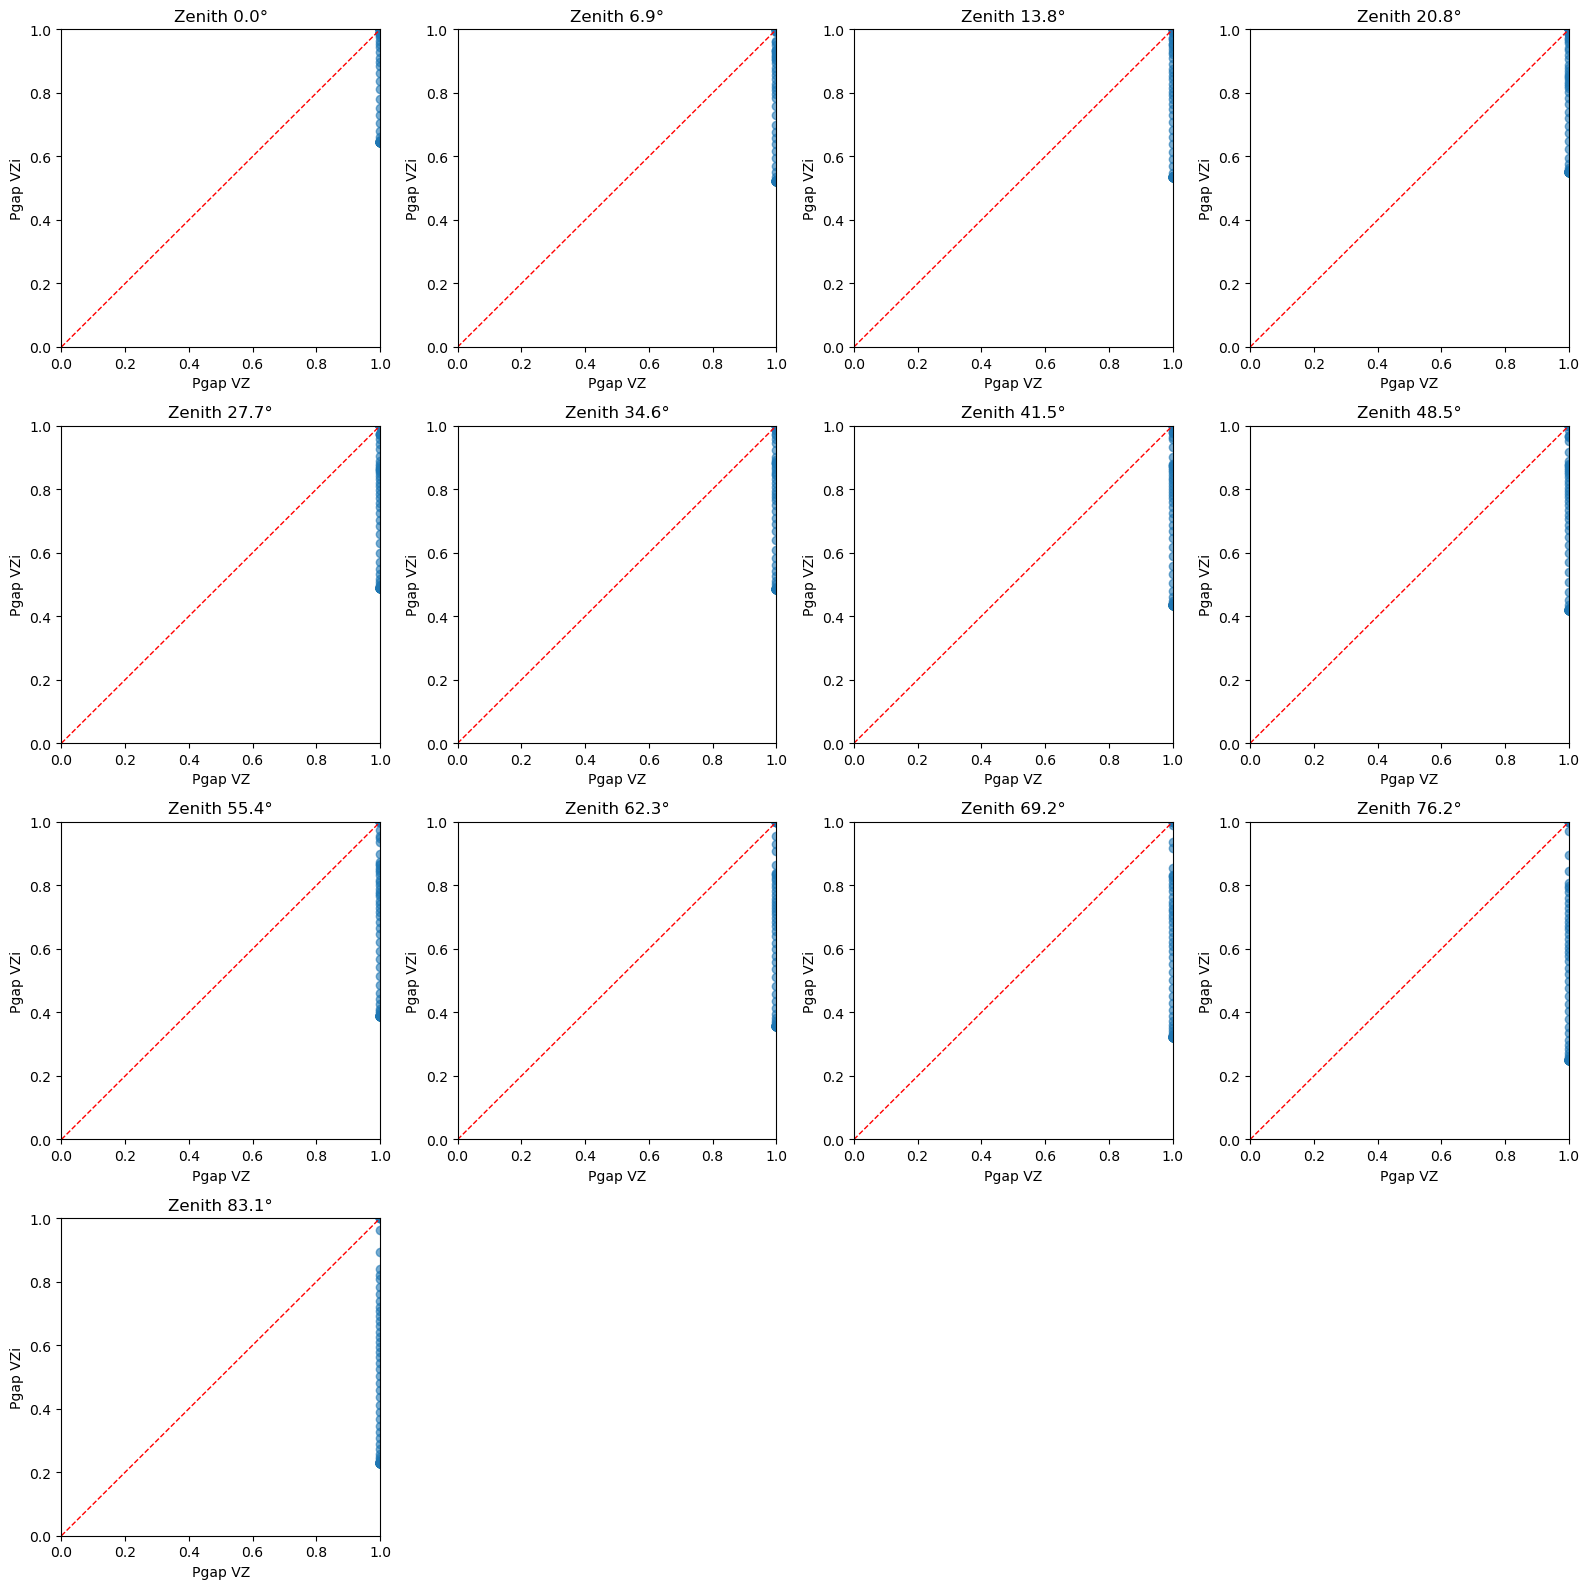

In [37]:
import matplotlib.pyplot as plt
import numpy as np

vpp_vz_f5.get_pgap_theta_z()
vpp_vzi_f5.get_pgap_theta_z()

# Extract arrays
pgap_vz = vpp_vz_f5.pgap_theta_z
pgap_vzi = vpp_vzi_f5.pgap_theta_z

# Get number of zenith bins
n_zenith_bins = pgap_vz.shape[0]
zenith_angles = np.linspace(0, 90, n_zenith_bins, endpoint=False)  # adjust if you know exact bins

# Plot
cols = 4
rows = (n_zenith_bins + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axs = axs.flatten()

for i in range(n_zenith_bins):
    vz_vals = pgap_vz[i, :]
    vzi_vals = pgap_vzi[i, :]

    axs[i].scatter(vz_vals, vzi_vals, alpha=0.6)
    axs[i].plot([0, 1], [0, 1], 'r--', lw=1)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 1)
    axs[i].set_title(f'Zenith {zenith_angles[i]:.1f}°')
    axs[i].set_xlabel('Pgap VZ')
    axs[i].set_ylabel('Pgap VZi')

# Remove any empty subplots
for j in range(n_zenith_bins, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

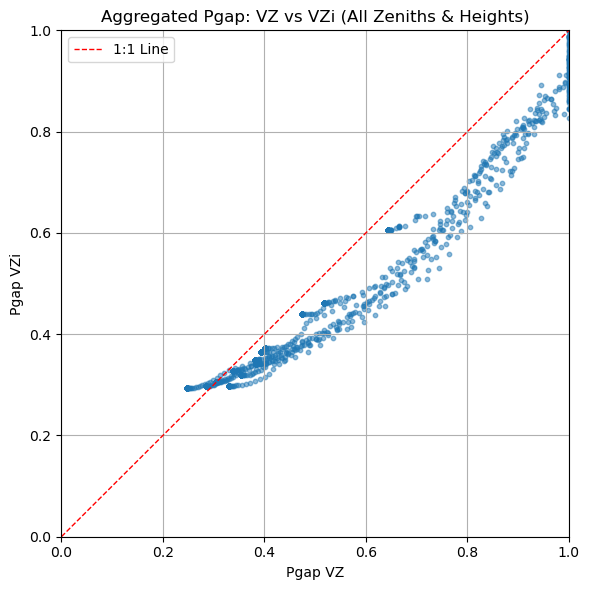

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Extract arrays
pgap_vz = vpp_vz_f5.pgap_theta_z
pgap_vzi = vpp_vzi_f5.pgap_theta_z

# Flatten both arrays
vz_vals = pgap_vz.flatten()
vzi_vals = pgap_vzi.flatten()

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(vz_vals, vzi_vals, alpha=0.5, s=10)
plt.plot([0, 1], [0, 1], 'r--', lw=1, label='1:1 Line')
plt.xlabel('Pgap VZ')
plt.ylabel('Pgap VZi')
plt.title('Aggregated Pgap: VZ vs VZi (All Zeniths & Heights)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

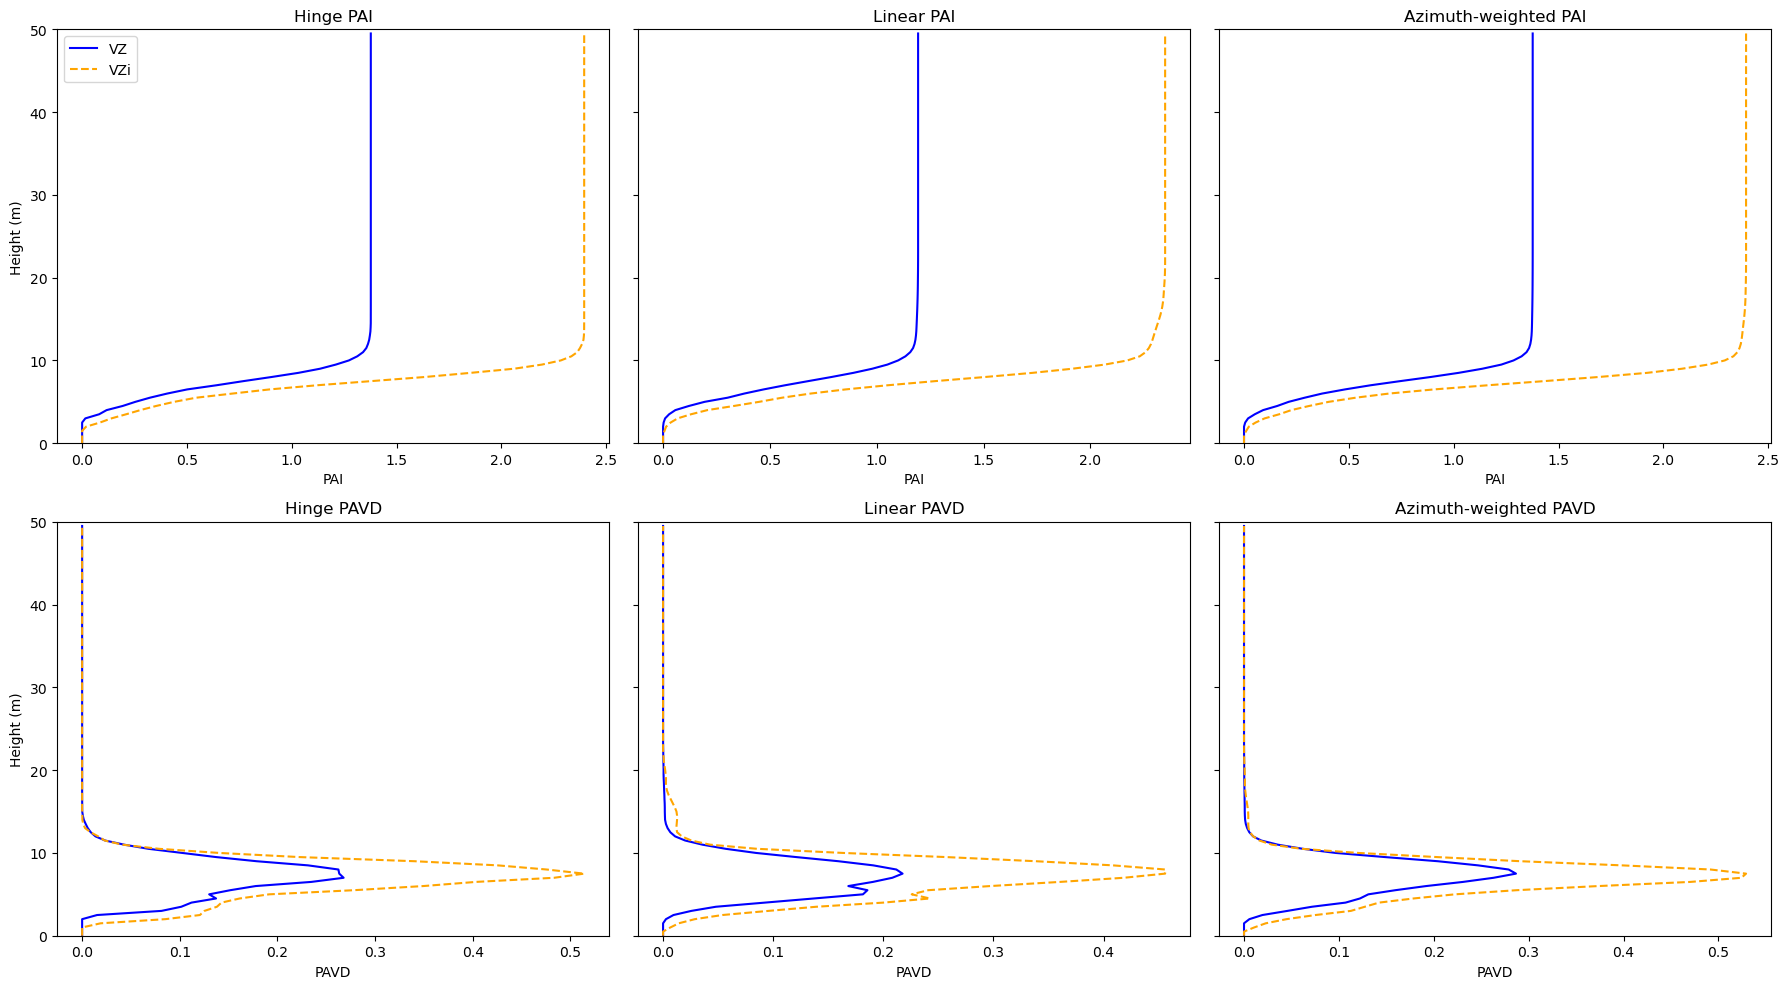

In [97]:
vz = vpp_vz_f1
vzi = vpp_vzi_f1

hinge_pai_vz = vz.calcHingePlantProfiles()
weighted_pai_vz  = vz.calcSolidAnglePlantProfiles()
linear_pai_vz  = vz.calcLinearPlantProfiles()

hinge_pavd_vz  = vz.get_pavd(hinge_pai_vz )
linear_pavd_vz  = vz.get_pavd(linear_pai_vz )
weighted_pavd_vz  = vz.get_pavd(weighted_pai_vz )

hinge_pai_vzi  = vzi.calcHingePlantProfiles()
weighted_pai_vzi  = vzi.calcSolidAnglePlantProfiles()
linear_pai_vzi  = vzi.calcLinearPlantProfiles()

hinge_pavd_vzi  = vzi.get_pavd(hinge_pai_vzi )
linear_pavd_vzi  = vzi.get_pavd(linear_pai_vzi )
weighted_pavd_vzi  = vzi.get_pavd(weighted_pai_vzi )


# Get height (z) array
z = vpp_vz_f1.height_bin    # assumes same z for all profiles

fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
height_min, height_max = 0, 50

# --- PAI ---

axs[0, 0].plot(hinge_pai_vz, z, label='VZ', color='blue')
axs[0, 0].plot(hinge_pai_vzi, z, label='VZi', color='orange', linestyle='--')
axs[0, 0].set_title('Hinge PAI')
axs[0, 0].set_xlabel('PAI')
axs[0, 0].set_ylabel('Height (m)')
axs[0, 0].set_ylim(height_min, height_max)
axs[0, 0].legend()

axs[0, 1].plot(linear_pai_vz, z, color='blue')
axs[0, 1].plot(linear_pai_vzi, z, color='orange', linestyle='--')
axs[0, 1].set_title('Linear PAI')
axs[0, 1].set_xlabel('PAI')
axs[0, 1].set_ylim(height_min, height_max)

axs[0, 2].plot(weighted_pai_vz, z, color='blue')
axs[0, 2].plot(weighted_pai_vzi, z, color='orange', linestyle='--')
axs[0, 2].set_title('Azimuth-weighted PAI')
axs[0, 2].set_xlabel('PAI')
axs[0, 2].set_ylim(height_min, height_max)

# --- PAVD ---

axs[1, 0].plot(hinge_pavd_vz, z, color='blue')
axs[1, 0].plot(hinge_pavd_vzi, z, color='orange', linestyle='--')
axs[1, 0].set_title('Hinge PAVD')
axs[1, 0].set_xlabel('PAVD')
axs[1, 0].set_ylabel('Height (m)')
axs[1, 0].set_ylim(height_min, height_max)

axs[1, 1].plot(linear_pavd_vz, z, color='blue')
axs[1, 1].plot(linear_pavd_vzi, z, color='orange', linestyle='--')
axs[1, 1].set_title('Linear PAVD')
axs[1, 1].set_xlabel('PAVD')
axs[1, 1].set_ylim(height_min, height_max)

axs[1, 2].plot(weighted_pavd_vz, z, color='blue')
axs[1, 2].plot(weighted_pavd_vzi, z, color='orange', linestyle='--')
axs[1, 2].set_title('Azimuth-weighted PAVD')
axs[1, 2].set_xlabel('PAVD')
axs[1, 2].set_ylim(height_min, height_max)

plt.tight_layout()
plt.show()

In [32]:
hinge_pai_vzi

array([-0.        , -0.        , -0.        , -0.        ,  0.01894077,
        0.08508035,  0.13955396,  0.21029104,  0.27758438,  0.35296449,
        0.43893014,  0.54447841,  0.71724264,  0.8938603 ,  1.12041421,
        1.37717798,  1.63451294,  1.85272397,  2.05999338,  2.19327024,
        2.28292635,  2.3335341 ,  2.36159928,  2.37471104,  2.38466392,
        2.39123196,  2.39329066,  2.39427406,  2.39440182,  2.39452323,
        2.39460591,  2.39460591,  2.39460591,  2.39460591,  2.39460591,
        2.39460591,  2.39460591,  2.39461112,  2.39461112,  2.39461112,
        2.39461112,  2.39461112,  2.39461112,  2.39461112,  2.39461112,
        2.39461112,  2.39461112,  2.39461112,  2.39461112,  2.39461112,
        2.39461112,  2.39461112,  2.39461112,  2.39461112,  2.39461112,
        2.39461112,  2.39461112,  2.39461112,  2.39461112,  2.39461112,
        2.39461112,  2.39461112,  2.39461112,  2.39461112,  2.39461112,
        2.39461112,  2.39461112,  2.39461112,  2.39461112,  2.39

In [33]:
hinge_pai_vz

array([-0.        , -0.        , -0.        , -0.        ,  0.01894077,
        0.08508035,  0.13955396,  0.21029104,  0.27758438,  0.35296449,
        0.43893014,  0.54447841,  0.71724264,  0.8938603 ,  1.12041421,
        1.37717798,  1.63451294,  1.85272397,  2.05999338,  2.19327024,
        2.28292635,  2.3335341 ,  2.36159928,  2.37471104,  2.38466392,
        2.39123196,  2.39329066,  2.39427406,  2.39440182,  2.39452323,
        2.39460591,  2.39460591,  2.39460591,  2.39460591,  2.39460591,
        2.39460591,  2.39460591,  2.39461112,  2.39461112,  2.39461112,
        2.39461112,  2.39461112,  2.39461112,  2.39461112,  2.39461112,
        2.39461112,  2.39461112,  2.39461112,  2.39461112,  2.39461112,
        2.39461112,  2.39461112,  2.39461112,  2.39461112,  2.39461112,
        2.39461112,  2.39461112,  2.39461112,  2.39461112,  2.39461112,
        2.39461112,  2.39461112,  2.39461112,  2.39461112,  2.39461112,
        2.39461112,  2.39461112,  2.39461112,  2.39461112,  2.39

In [32]:
vpp_vz_f1.height_bin

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
       44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
       49.5])

In [86]:
vzi = all_paths_df.loc[(all_paths_df['project_path'] == '2024-04-08-BOSLAND-1i.RiSCAN') & 
                 (all_paths_df['resolution'] == 0.03) &
                 (all_paths_df['frequency'] == 300)]


scans = vzi

rdbx_file = scans['rdb_v'].iloc[0]
rxp_file = scans['rxp_v'].iloc[0]
upright_transform_fn = scans['dat_v'].iloc[0]


tilt_rdbx_fn = scans['rdb_h'].iloc[0]
tilt_rxp_fn = scans['rxp_h'].iloc[0]
tilt_transform_fn = scans['dat_h'].iloc[0]

terrain_params = np.array([scans['parameter_c'].iloc[0], scans['parameter_a'].iloc[0], scans['parameter_b'].iloc[0]])

vpp_vzi2 = plant_profile.Jupp2009(hres=0.5, 
                                zres=5, 
                                ares=360,
                                min_z=5, 
                                max_z=70, 
                                min_h=0, 
                                max_h=50,
                                ground_plane=terrain_params)


# If using RXP files only as input, set rdbx_file to None (the default)
query_str = ['reflectance > -20']
vpp_vzi2.add_riegl_scan_position(rxp_file, 
                                upright_transform_fn, 
                                sensor_height=None,
                                rdbx_file=rdbx_file, 
                                method='FIRST', 
                                min_zenith=5, 
                                max_zenith=70,
                                query_str=query_str)


In [101]:
vzi = all_paths_df.loc[(all_paths_df['project_path'] == '2024-04-08-BOSLAND-1i.RiSCAN') & 
                 (all_paths_df['resolution'] == 0.03) &
                 (all_paths_df['frequency'] == 300)]


scans = vzi

rdbx_file = scans['rdb_v'].iloc[0]
rxp_file = scans['rxp_v'].iloc[0]
upright_transform_fn = scans['dat_v'].iloc[0]


tilt_rdbx_fn = scans['rdb_h'].iloc[0]
tilt_rxp_fn = scans['rxp_h'].iloc[0]
tilt_transform_fn = scans['dat_h'].iloc[0]

header = riegl_rdb.readFile(rdbx_file)

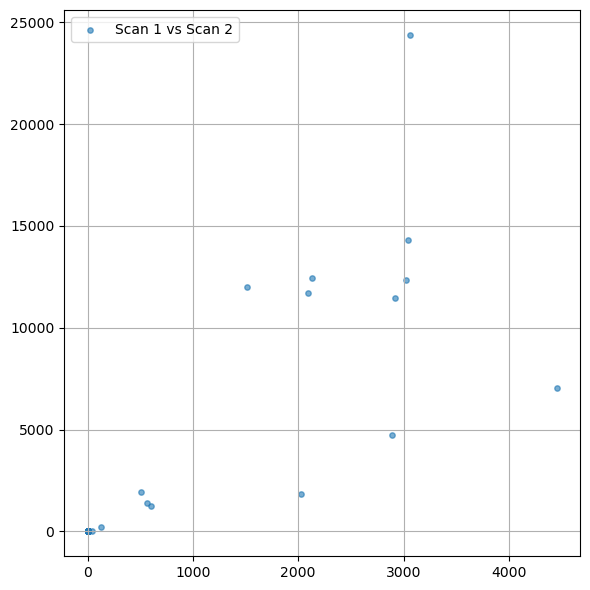

In [114]:
# Flatten each target_output
x1 = vpp_vz.target_output[4]
x2 = vpp_vzi.target_output[4]
x3 = vpp_vzi2.target_output.flatten()

# Plot
plt.figure(figsize=(6, 6))

plt.scatter(x1, x2, alpha=0.6, label='Scan 1 vs Scan 2', s=15)

plt.grid(True)
plt.legend()
plt.tight_layout()


In [ ]:
vzi2 = all_paths_df.loc[(all_paths_df['project_path'] == '2024-04-08-BOSLAND-1i.RiSCAN') & 
                 (all_paths_df['resolution'] == 0.03) &
                 (all_paths_df['frequency'] == 600)]


scans = vzi2

rdbx_file = scans['rdb_v'].iloc[0]
rxp_file = scans['rxp_v'].iloc[0]
upright_transform_fn = scans['dat_v'].iloc[0]


tilt_rdbx_fn = scans['rdb_h'].iloc[0]
tilt_rxp_fn = scans['rxp_h'].iloc[0]
tilt_transform_fn = scans['dat_h'].iloc[0]

terrain_params = np.array([scans['parameter_c'].iloc[0], scans['parameter_a'].iloc[0], scans['parameter_b'].iloc[0]])

vpp_vzi2 = plant_profile.Jupp2009(hres=0.5, 
                                zres=5, 
                                ares=360,
                                min_z=5, 
                                max_z=70, 
                                min_h=0, 
                                max_h=50,
                                ground_plane=terrain_params)


# If using RXP files only as input, set rdbx_file to None (the default)
query_str = ['reflectance > -20']
vpp_vzi2.add_riegl_scan_position(rxp_file, 
                            upright_transform_fn, 
                            sensor_height=None,
                            rdbx_file=rdbx_file, 
                            method='FIRST', 
                            min_zenith=5, 
                            max_zenith=70,
                            query_str=query_str)

In [51]:
# For matrix1
zenith_counts1 = vpp_vz.shot_output.sum(axis=(1, 2))  # shape: (13,)

# For matrix2
zenith_counts2 = vpp_vzi.shot_output.sum(axis=(1, 2))  # shape: (13,)


# Element-wise difference
difference = zenith_counts2 - zenith_counts1

# Optional: view as a table
for i, (z1, z2, diff) in enumerate(zip(zenith_counts1, zenith_counts2, difference)):
    print(f"Zenith bin {i}: Matrix1 = {z1}, Matrix2 = {z2}, Difference = {diff}")

Zenith bin 0: Matrix1 = 0.0, Matrix2 = 0.0, Difference = 0.0
Zenith bin 1: Matrix1 = 0.0, Matrix2 = 0.0, Difference = 0.0
Zenith bin 2: Matrix1 = 0.0, Matrix2 = 0.0, Difference = 0.0
Zenith bin 3: Matrix1 = 0.0, Matrix2 = 0.0, Difference = 0.0
Zenith bin 4: Matrix1 = 64239.0, Matrix2 = 210630.0, Difference = 146391.0
Zenith bin 5: Matrix1 = 1948057.0, Matrix2 = 1857882.0, Difference = -90175.0
Zenith bin 6: Matrix1 = 2014322.0, Matrix2 = 2001156.0, Difference = -13166.0
Zenith bin 7: Matrix1 = 2014291.0, Matrix2 = 2000614.0, Difference = -13677.0
Zenith bin 8: Matrix1 = 2013903.0, Matrix2 = 2000379.0, Difference = -13524.0
Zenith bin 9: Matrix1 = 2013665.0, Matrix2 = 1999948.0, Difference = -13717.0
Zenith bin 10: Matrix1 = 2013258.0, Matrix2 = 1999574.0, Difference = -13684.0
Zenith bin 11: Matrix1 = 2013799.0, Matrix2 = 1999426.0, Difference = -14373.0
Zenith bin 12: Matrix1 = 2013393.0, Matrix2 = 1999365.0, Difference = -14028.0


In [59]:

pgap_phi_z = []
for az in range(0, 360, vpp_vz.ares):
            # Set invert to True if min_azimuth and max_azimuth specify the range to exclude
            vpp_vz.get_pgap_theta_z(min_azimuth=az, max_azimuth=az+vpp_vz.ares, invert=False)
            pgap_phi_z.append(vpp_vz.pgap_theta_z[hinge_idx])

NameError: name 'hinge_idx' is not defined

In [55]:
vpp_vz.calcHingePlantProfiles()

AttributeError: 'Jupp2009' object has no attribute 'pgap_theta_z'

In [9]:
import numpy as np

# Convert to (7,) by summing over azimuth
zenith_vz = vpp_vz.shot_output.squeeze().sum(axis=1)  # shape: (7,)
zenith_vzi = vpp_vzi.shot_output.squeeze().sum(axis=1)
#zenith_vzi2 = vpp_vzi2.shot_output.squeeze().sum(axis=1)



In [24]:
vpp_vz.target_output.squeeze().sum(axis=1)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [38]:
vpp_vz.target_output.shape

(13, 4, 100)

In [ ]:
vpp_vzi.target_output

(13, 4, 100)

In [ ]:
# Convert to (7,) by summing over azimuth
zenith_vz = vpp_vz.shot_output.squeeze().sum(axis=1)  # shape: (7,)
zenith_vzi = vpp_vzi.shot_output.squeeze().sum(axis=1)
zenith_vzi2 = vpp_vzi2.shot_output.squeeze().sum(axis=1)

In [12]:
diff = zenith_vz - zenith_vzi
abs_diff = np.abs(diff)

print("Absolute difference per zenith bin:", abs_diff)
print("Mean difference:", abs_diff.mean())
print("Max difference:", abs_diff.max())


Absolute difference per zenith bin: [     0.      0.      0.      0. 146391.  90175.  13166.  13677.  13524.
  13717.  13684.  14373.  14028.]
Mean difference: 25595.0
Max difference: 146391.0


In [17]:
len(zenith_vz)

13

In [16]:
zenith_vzi

array([      0.,       0.,       0.,       0.,  210630., 1857882.,
       2001156., 2000614., 2000379., 1999948., 1999574., 1999426.,
       1999365.], dtype=float32)

In [ ]:
corre

array([2014322., 2014291., 2013903., 2013665., 2013258., 2013799.,
       2013393.], dtype=float32)

In [39]:
zenith_vzi

array([2001156., 2000614., 2000379., 1999948., 1999574., 1999426.,
       1999365.], dtype=float32)

In [34]:
zenith_vzi2

array([1873162., 2017842., 2017585., 2017302., 2017103., 2016942.,
       2016756., 2016694., 2016584., 2016629., 2016514., 2016569.,
       2016646., 2016571., 2016698., 2016652., 2016767., 2016949.,
       2017113., 1872281.], dtype=float32)

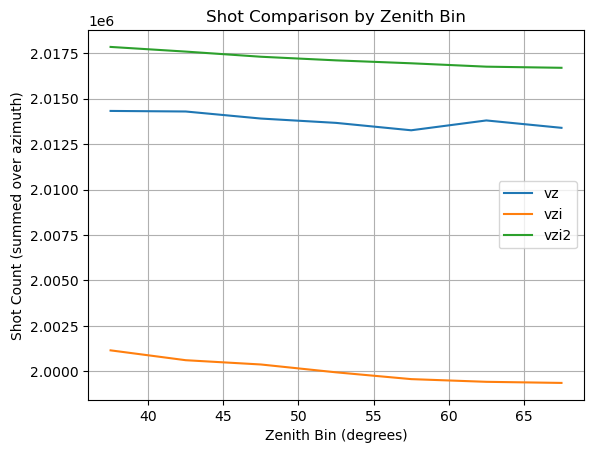

In [43]:
import matplotlib.pyplot as plt

zenith_labels = vpp_vz.zenith_bin  # if available

plt.plot(zenith_labels, zenith_vz, label="vz")
plt.plot(zenith_labels, zenith_vzi, label="vzi")
plt.plot(zenith_labels, zenith_vzi2, label="vzi2")

plt.xlabel("Zenith Bin (degrees)")
plt.ylabel("Shot Count (summed over azimuth)")
plt.title("Shot Comparison by Zenith Bin")
plt.legend()
plt.grid(True)
plt.show()


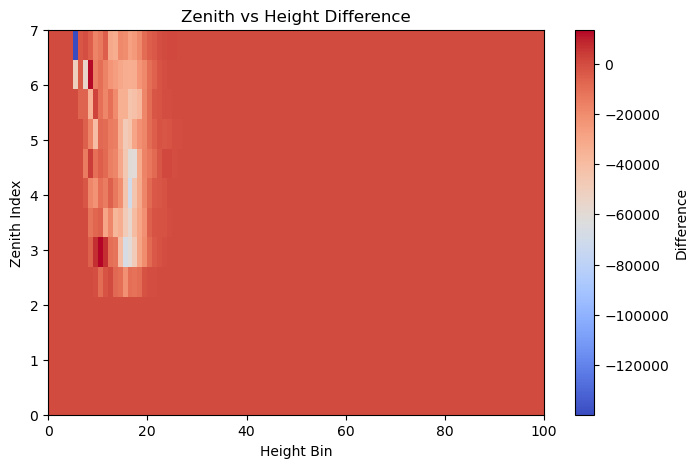

In [72]:
diff = targets_vz - targets_vzi
plt.figure(figsize=(8, 5))
plt.imshow(diff, aspect='auto', origin='lower', cmap='coolwarm',
           extent=[0, 100, 0, 7])  # height (x), zenith (y)
plt.colorbar(label='Difference')
plt.xlabel('Height Bin')
plt.ylabel('Zenith Index')
plt.title('Zenith vs Height Difference')
plt.show()

/tmp/ipykernel_2326063/431357495.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


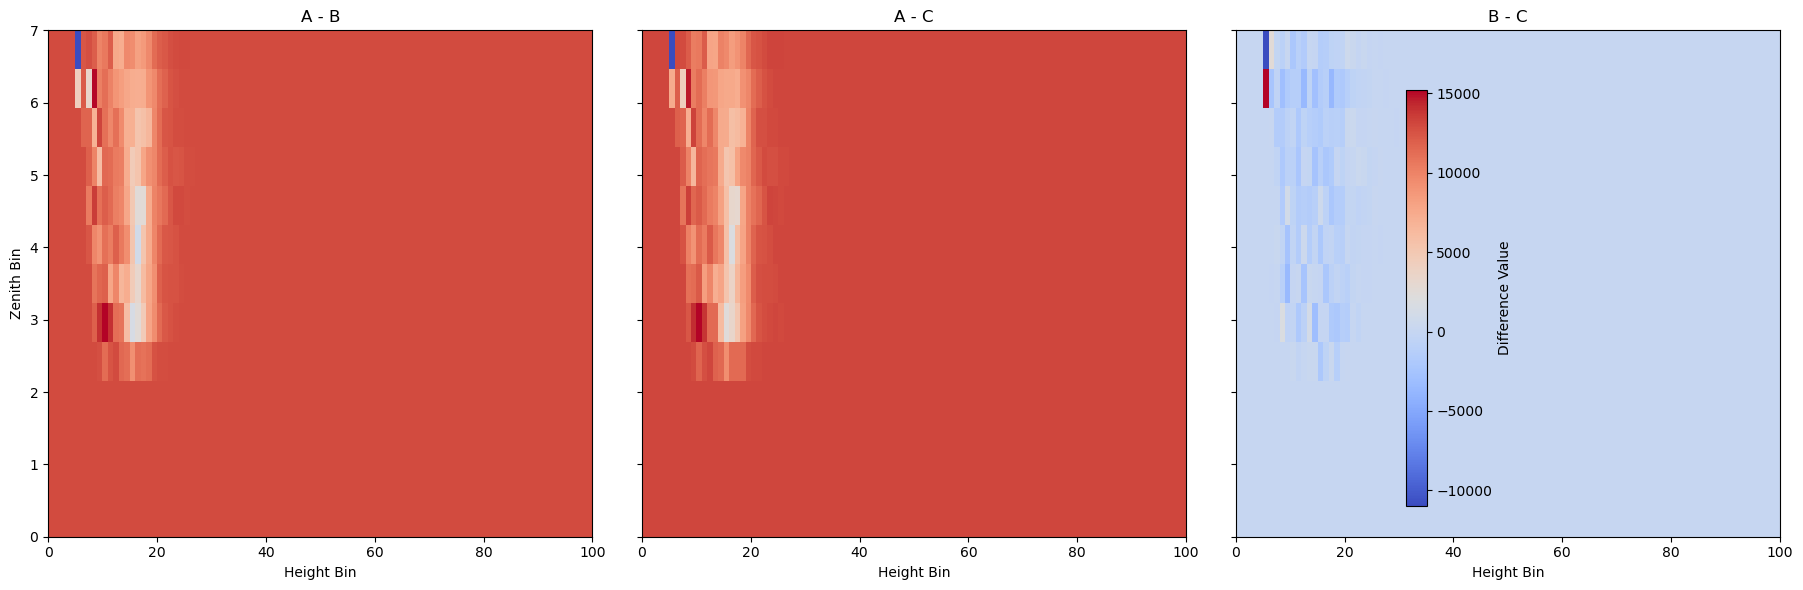

In [71]:
# --- Compute difference matrices ---
diff_AB = targets_vz - targets_vzi
diff_AC = targets_vz - targets_vzi2
diff_BC = targets_vzi - targets_vzi2

# --- Plot all differences ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

im1 = axs[0].imshow(diff_AB, aspect='auto', origin='lower', cmap='coolwarm', extent=[0, 100, 0, 7])
axs[0].set_title("A - B")
axs[0].set_xlabel("Height Bin")
axs[0].set_ylabel("Zenith Bin")

im2 = axs[1].imshow(diff_AC, aspect='auto', origin='lower', cmap='coolwarm', extent=[0, 100, 0, 7])
axs[1].set_title("A - C")
axs[1].set_xlabel("Height Bin")

im3 = axs[2].imshow(diff_BC, aspect='auto', origin='lower', cmap='coolwarm', extent=[0, 100, 0, 7])
axs[2].set_title("B - C")
axs[2].set_xlabel("Height Bin")

# --- Shared colorbar ---
cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink=0.9)
cbar.set_label("Difference Value")

plt.tight_layout()
plt.show()

In [ ]:
vpp_vz.pgap_theta_z.shape
vpp_

AttributeError: 'Jupp2009' object has no attribute 'pgap_theta_z'